## Visualise the price movements of the different regimes

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bt
import talib
from ta.volatility import AverageTrueRange


In [374]:
data = pd.read_csv('../data/backtest_data_with_technical_indicators.csv')
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index)
atr = AverageTrueRange(high=data['High'], low=data['Low'], close=data['Close'], window=20)
data['ATR']=atr.average_true_range()
data['5atr_above_ema'] = data['ema_20'] + 5 * data['ATR']
data['5atr_below_ema'] = data['ema_20'] - 5 * data['ATR']
data['4atr_above_ema'] = data['ema_20'] + 4 * data['ATR']
data['4atr_below_ema'] = data['ema_20'] - 4 * data['ATR']
data['3atr_above_ema'] = data['ema_20'] + 3 * data['ATR']
data['3atr_below_ema'] = data['ema_20'] - 3 * data['ATR']
data['2atr_above_ema'] = data['ema_20'] + 2 * data['ATR']
data['2atr_below_ema'] = data['ema_20'] - 2 * data['ATR']
data['1atr_above_ema'] = data['ema_20'] + data['ATR']
data['1atr_below_ema'] = data['ema_20'] - data['ATR']
# Calculate the percentage change for 'Close' column
data['log_pct_change'] = np.log(data['Close']/data['Close'].shift(1))
# To fill the NaN values in the first row (as it doesn't have a previous day to calculate the percentage change from), you can use fillna() function
data.dropna(inplace=True)

In [375]:
# Assume slippage and commission are 1 basis point each
slippage = 0.01 / 100
commission = 0.01 / 100


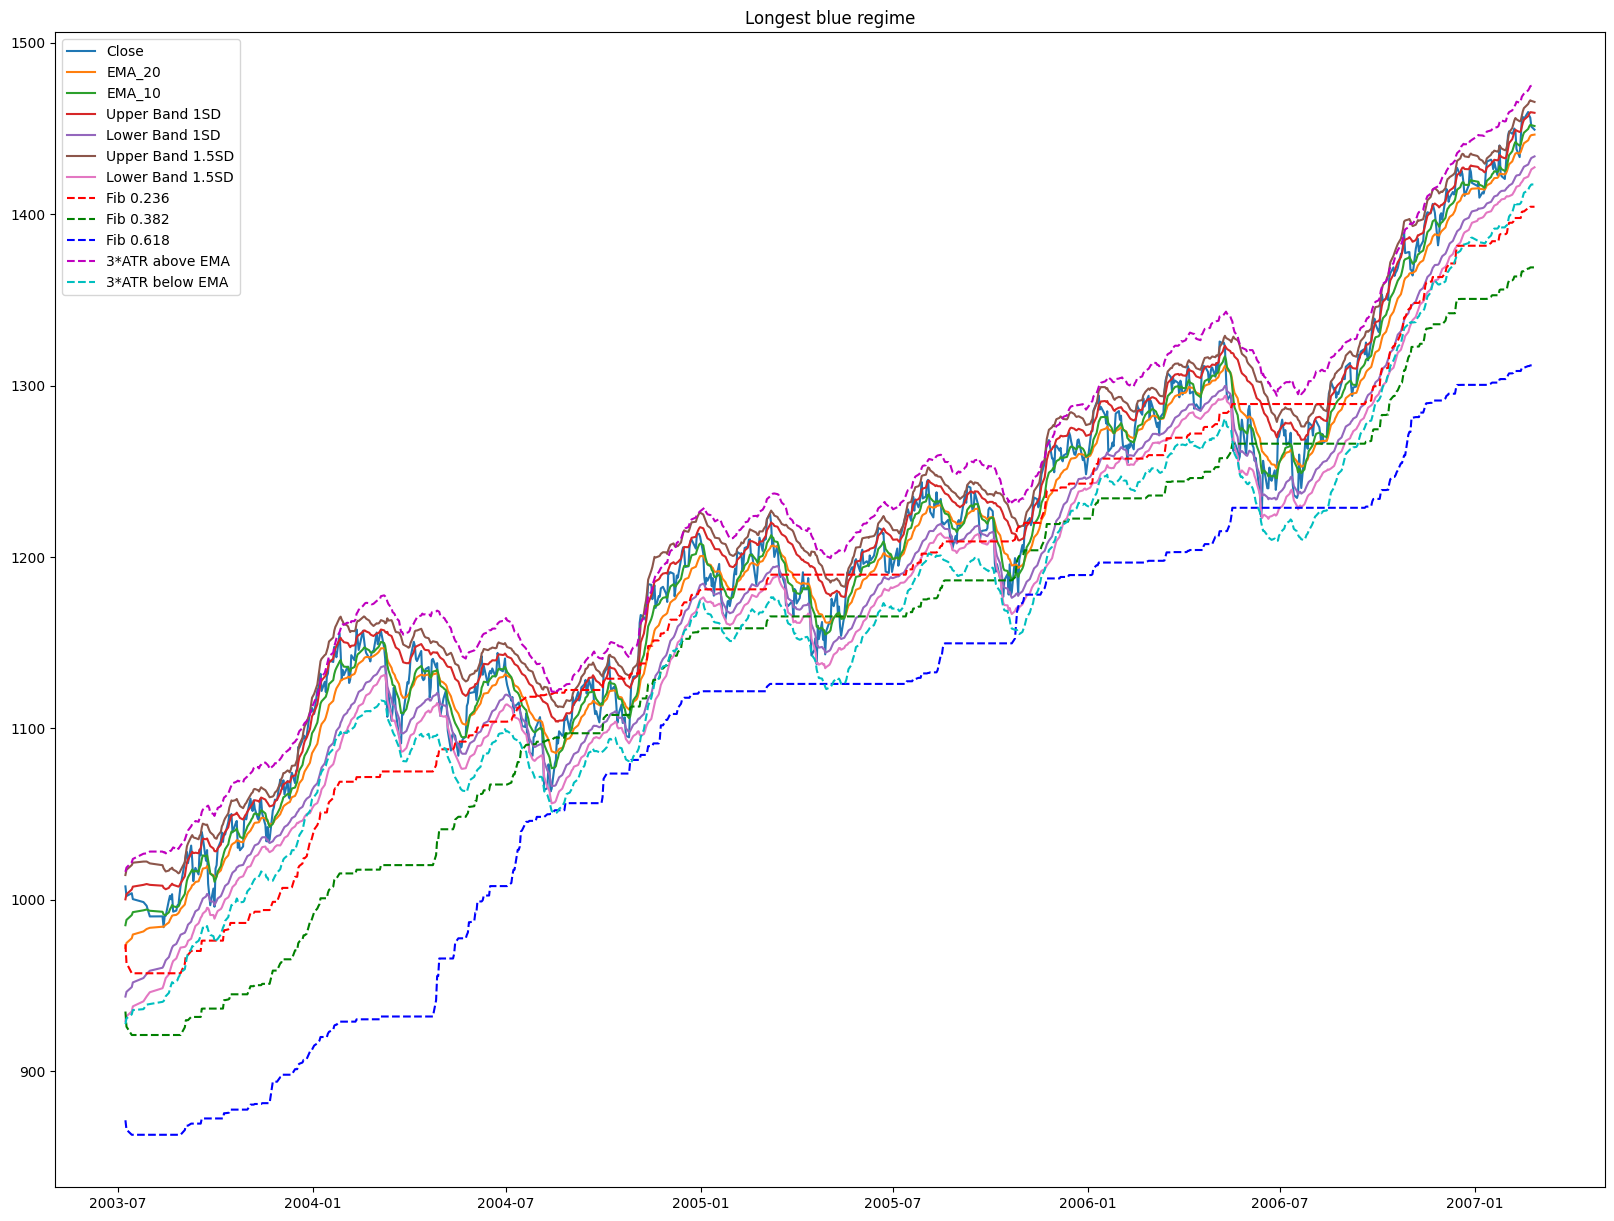

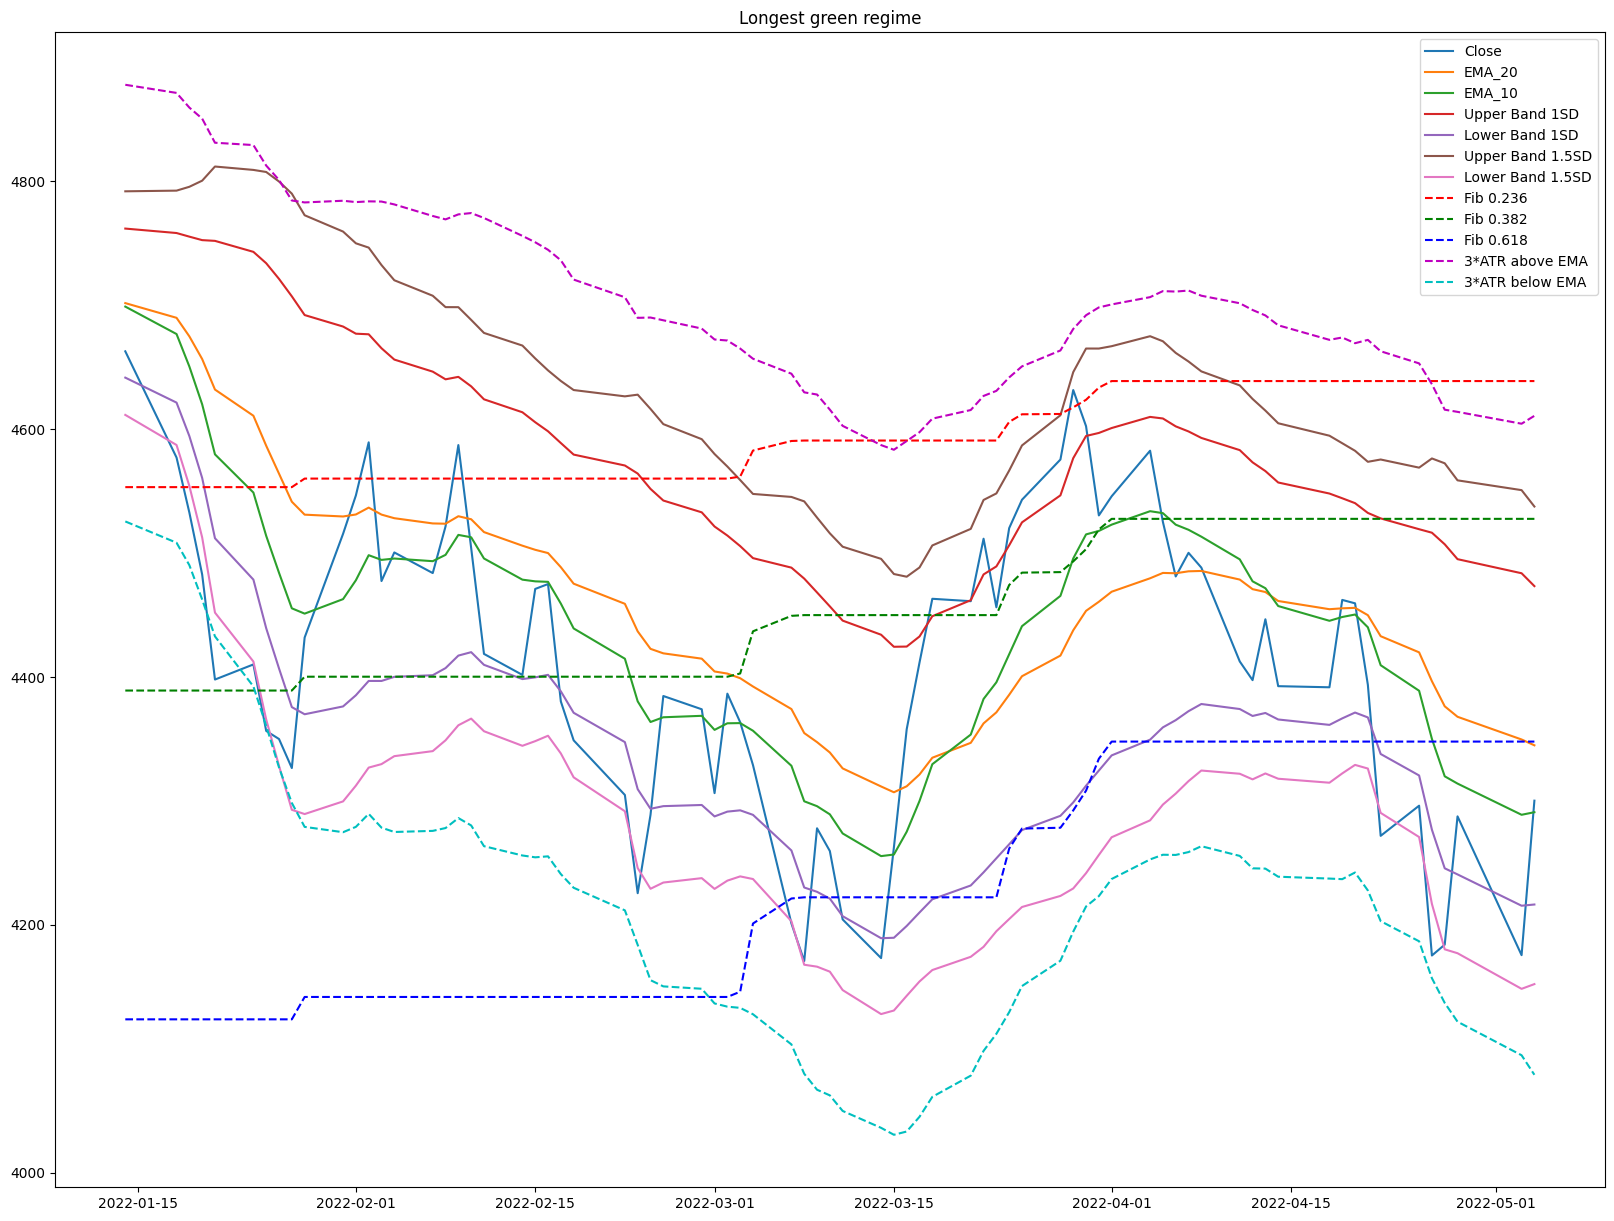

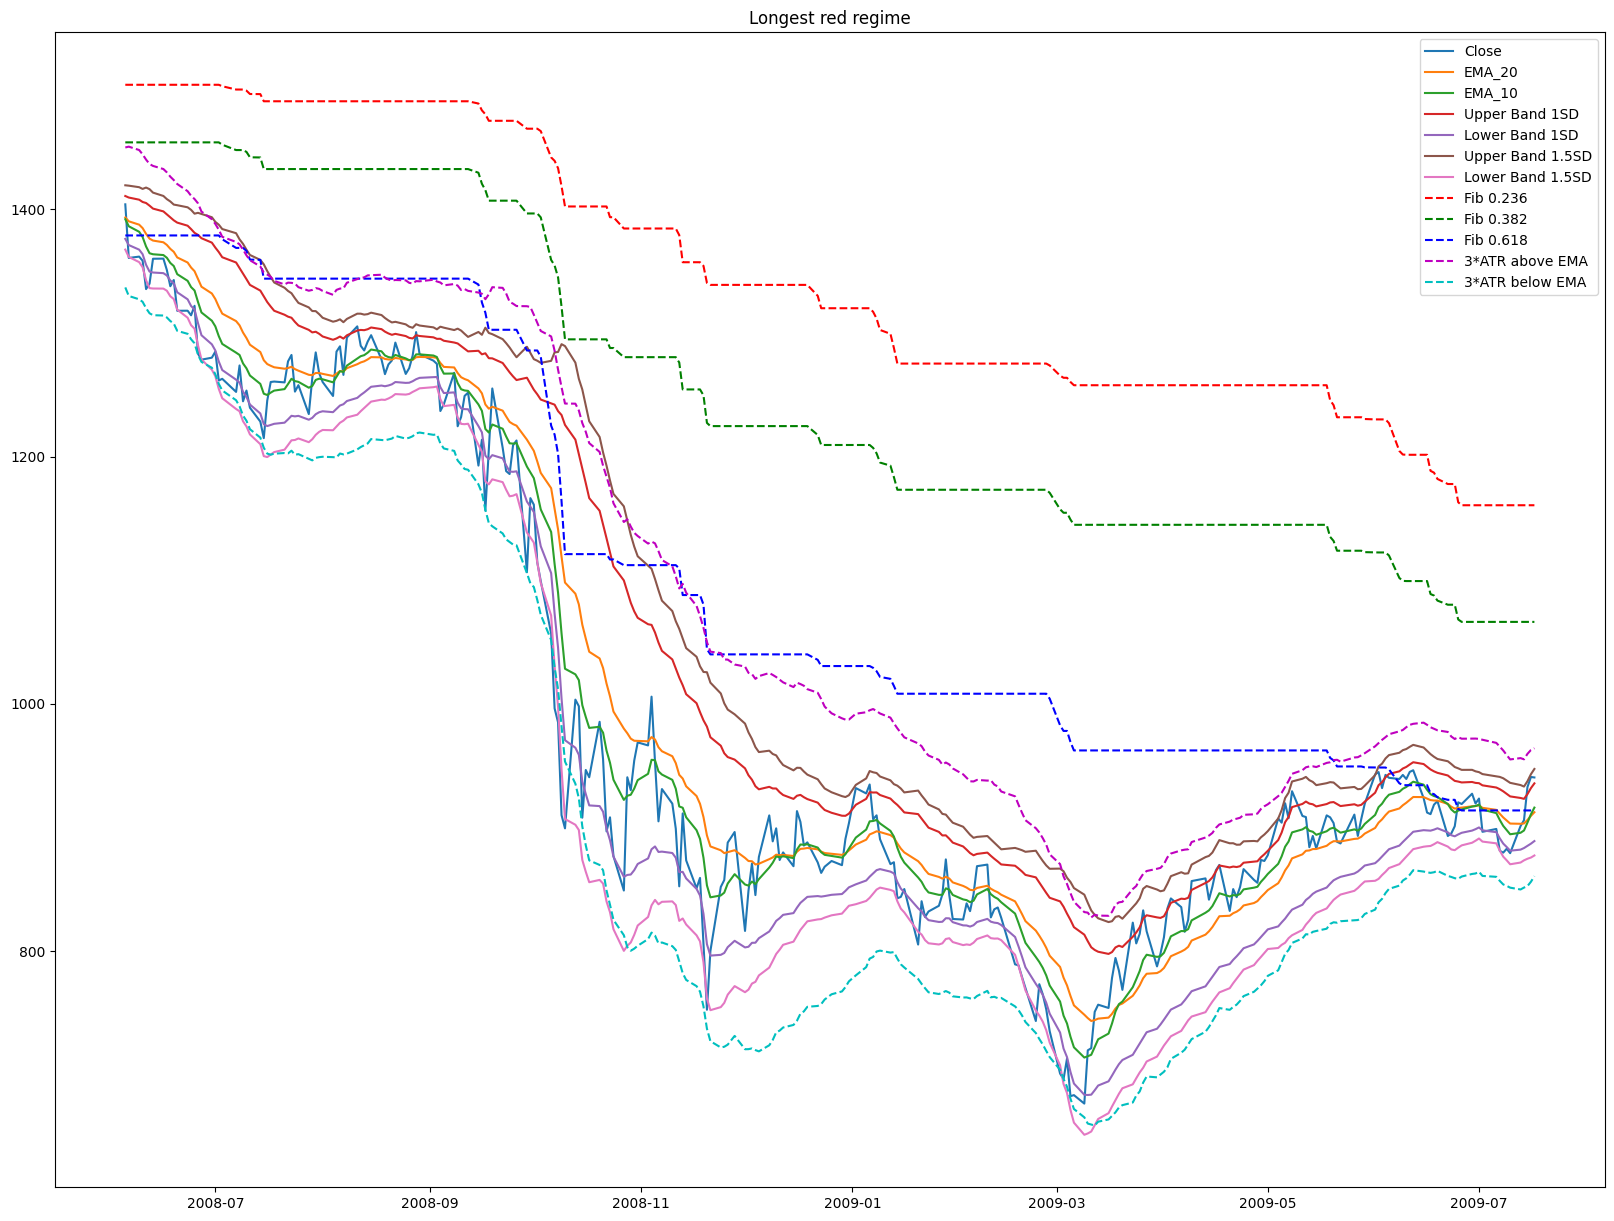

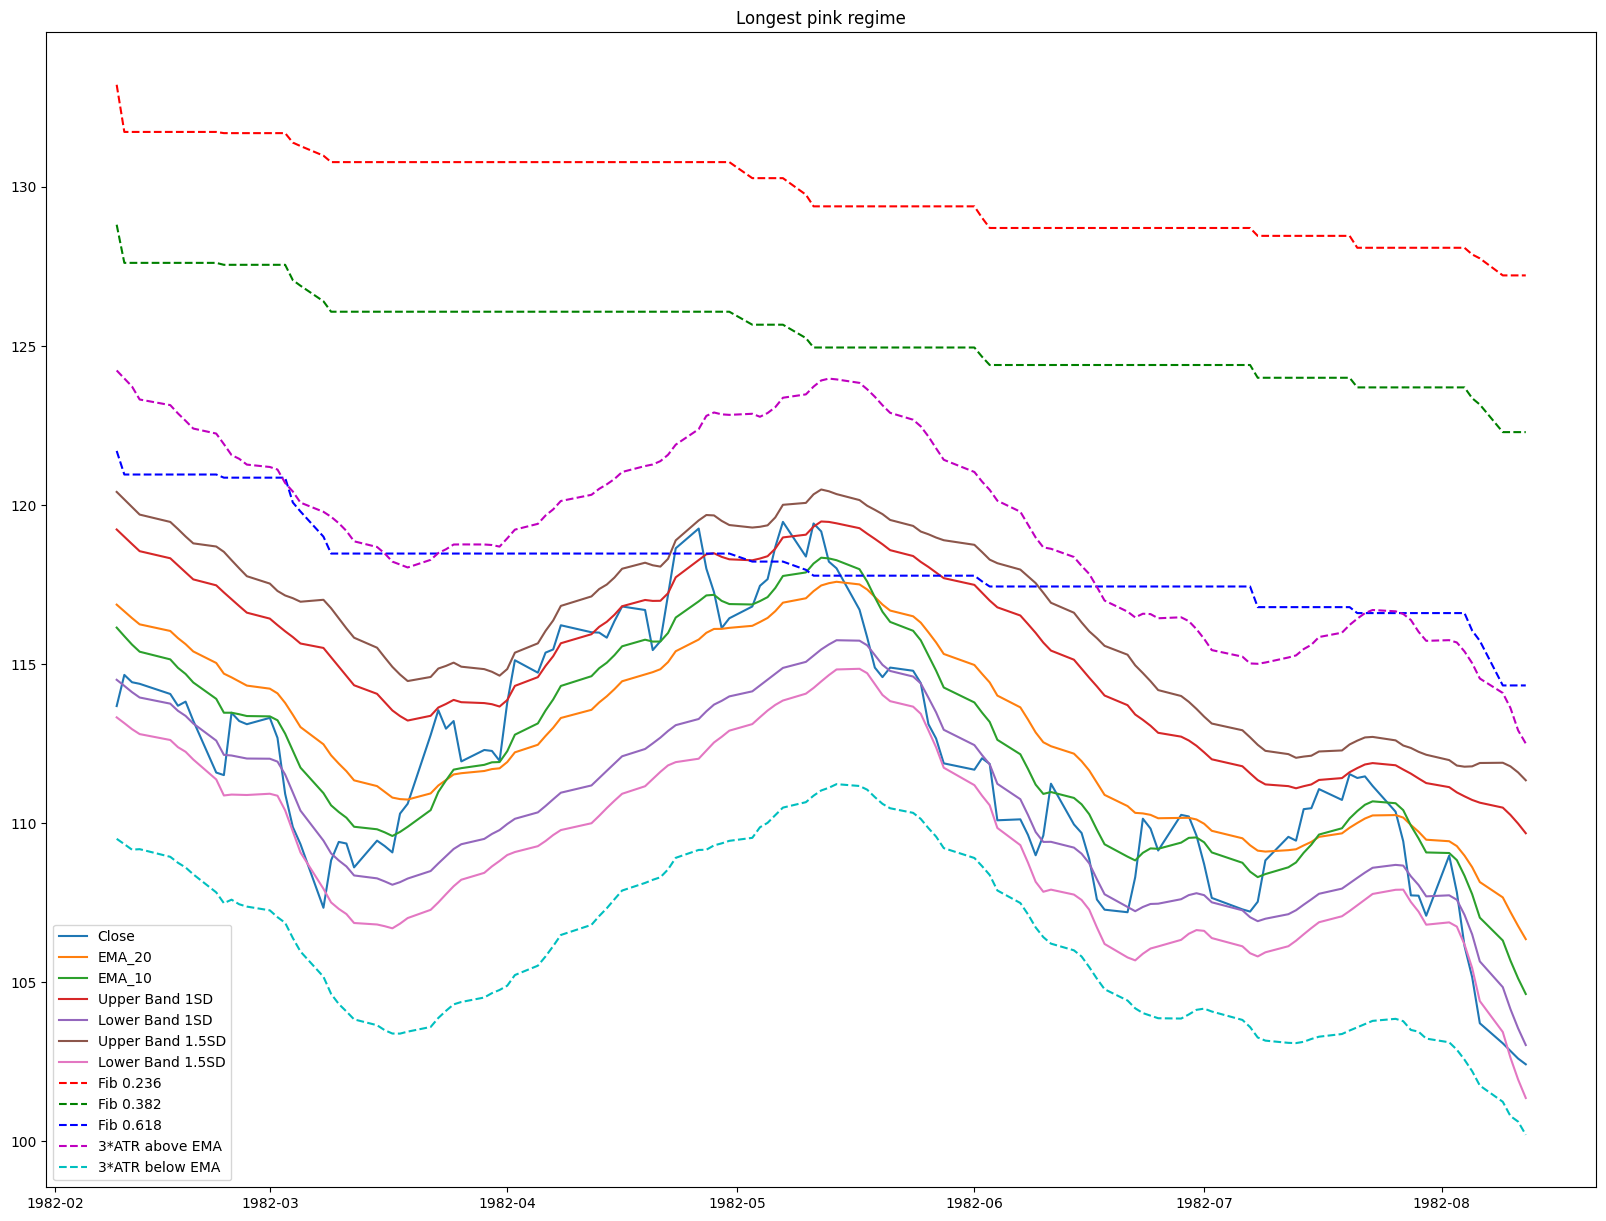

In [376]:
# Define the regimes
regimes = data['regime'].unique()

# Create a dictionary to store the dataframes
regime_dfs = {}

# Iterate over each regime
for regime in regimes:
    # Create a boolean series where True indicates a change in regime or a change from the current regime
    data['regime_change'] = (data['regime'].shift() != data['regime']) | (data['regime'] != regime)

    # Create a series that groups the data into continuous regimes
    data['regime_group'] = data['regime_change'].cumsum()

    # Count the number of rows in each group
    group_counts = data.groupby('regime_group').size()

    # Find the group with the maximum count
    max_group = group_counts.idxmax()

    # Filter the data for the longest continuous regime
    longest_regime = data[(data['regime_group'] == max_group) & (data['regime'] == regime)]

    # Drop the helper columns
    longest_regime = longest_regime.drop(columns=['regime_change', 'regime_group'])

    # Store the dataframe in the dictionary
    regime_dfs[regime] = longest_regime
    

for regime, df in regime_dfs.items():
    # Create a new figure
    plt.figure(figsize=(20,15))

    # Plot the 'Close' column
    plt.plot(df['Close'], label='Close')

    # Plot the EMA
    plt.plot(df['ema_20'], label='EMA_20')
    plt.plot(df['ema_10'], label='EMA_10')

    # Plot the Bollinger Bands for 1 standard deviation
    plt.plot(df['upper_band_1sd'], label='Upper Band 1SD')
    plt.plot(df['lower_band_1sd'], label='Lower Band 1SD')

    # Plot the Bollinger Bands for 1.5 standard deviations
    plt.plot(df['upper_band_1.5sd'], label='Upper Band 1.5SD')
    plt.plot(df['lower_band_1.5sd'], label='Lower Band 1.5SD')

    # Plot the Fibonacci Levels
    plt.plot(df['fib_level_0.236'], color='r', linestyle='--', label='Fib 0.236')
    plt.plot(df['fib_level_0.382'], color='g', linestyle='--', label='Fib 0.382')
    plt.plot(df['fib_level_0.618'], color='b', linestyle='--', label='Fib 0.618')
    
    # Plot 3*ATR above and below EMA_20
    plt.plot(df['3atr_above_ema'], color='m', linestyle='--', label='3*ATR above EMA')
    plt.plot(df['3atr_below_ema'], color='c', linestyle='--', label='3*ATR below EMA')

    # Set the title
    plt.title(f'Longest {regime} regime')

    # Show the legend
    plt.legend()

# Show the plots
plt.show()

## Advance (Bullish Low Variance)

Follow up trend  
Go long on pullbacks and breakouts  

LONG Bullish low var - Lower band crossover 1SD, , Lower band crossover 1.5SD, Lower band crossover 2SD, Upper band crossover 2SD  
LONG Bullish low var -  Fib 0.382, Fib 0.5, 0.236  
LONG Bullihs low var - All, especially RSI 30 and 40  

FINAL STRAT

LONG: Lower band crossover 1.5SD  
Fib 0.382  
RSI 30  

EXIT: Upper band crossover 1.5SD  
fib 0.618  
RSI 70  
Price cross below 10 day EMA  
Take profit EMA + 3*ATR  
Stop Loss EMA - 3*ATR

In [434]:
# Initialize 'signal' column with 0
data['signal_blue'] = 0

# Define conditions for going long
long_conditions = (
    ((data['lower_band_1.5sd'] > data['Close']) |  # Lower band crossover 1.5SD
    (data['fib_level_0.382'] > data['Close']) |  # Fib 0.382
    (data['RSI'] < 30) ) # RSI 40
    # &  (data['regime'] == 'blue')  # Only enter trades in 'blue' regime
)

# Define conditions for exiting
exit_conditions = (
    (data['upper_band_1.5sd'] < data['Close']) |  # Upper band crossover 1.5SD
    ((data['fib_level_0.618'].shift(1) < data['Close'].shift(1)) & (data['fib_level_0.618'] > data['Close'])) |  # fib 0.618, price goes from higher to below the level
    (data['RSI'] > 70) |  # RSI 70
    ((data['ema_10'].shift(1) < data['Close'].shift(1)) & (data['ema_10'] > data['Close'])) |  # Price cross below 10 day EMA, price goes from higher to below the level
    (data['3atr_above_ema'] <= data['Close']) |  # Take profit EMA + 3*ATR
    (data['3atr_below_ema'] >= data['Close'])  # Stop Loss EMA - 3*ATR
    # | (data['regime'] != 'blue')  # Exit trades when not in 'blue' regime
)

# Initialize a variable to keep track of whether we're currently long or not
in_long_trade = False

# Iterate over the DataFrame rows
for i in range(len(data)):
    # If we're not currently in a long trade and the long conditions are met, enter a long trade
    if not in_long_trade and long_conditions.iloc[i]:
        data.iloc[i, data.columns.get_loc('signal_blue')] = 1
        in_long_trade = True
    # If we're currently in a long trade and the exit conditions are met, exit the trade
    elif in_long_trade and exit_conditions.iloc[i]:
        data.iloc[i, data.columns.get_loc('signal_blue')] = 0
        in_long_trade = False
    # If we're currently in a long trade and no exit condition is met, continue the trade
    elif in_long_trade:
        data.iloc[i, data.columns.get_loc('signal_blue')] = 1

In [435]:

# Adjust the log returns for slippage and commission
data['blue_regime_strategy'] = data['signal_blue'].shift(1) * (data['log_pct_change'] - slippage - commission)

# Calculate the final value of the investment
final_value_blue = np.exp(data['blue_regime_strategy']).prod()

# Calculate the number of years
years = (data.index[-1] - data.index[0]).days / 252.0

# Calculate the CAGR
cagr_blue = (final_value_blue / 1) ** (1/years) - 1

cagr_blue

0.004705350845623402

## Accumulation (Bullish High Var)

Long lows of the range  
Stop loss above support, Take profit Swing High  

LONG Bullish high var -  Upper band crossover 1.5SD, Upper band Crossover 2SD  
LONG Bullish high var -  Fib 0.5, Fib 0.618  
LONG Bullish high var - RSI 30  
SHORT Bullish high var - RSI 60  

FINAL STRAT

LONG: Upper Band crossover 1.5SD  
Fib 0.618  
RSI 30  

EXIT:  
Upper Band crossover 1SD  
RSI 60  
Price cross below 10 day EMA  
Fib 0.236  
Take profit EMA + 3*ATR  
Stop Loss EMA - 2*ATR

In [440]:
# Initialize 'signal' column with 0
data['signal_green'] = 0

# Define conditions for going long
long_conditions = (
    ((data['upper_band_1.5sd'] < data['Close']) |  # Upper Band crossover 1.5SD
    ((data['fib_level_0.618'].shift(1) < data['Close'].shift(1)) & (data['fib_level_0.618'] > data['Close'])) |  # Fib 0.618, price goes from higher to below the level
    (data['RSI'] < 30)  ) # RSI 30
    # & (data['regime'] == 'green')  # Only enter trades in 'green' regime
    
)

# Define conditions for exiting
exit_conditions = (
    (data['upper_band_1sd'] < data['Close']) |  # Upper Band crossover 1SD
    (data['RSI'] > 60) |  # RSI 60
    ((data['ema_10'].shift(1) < data['Close'].shift(1)) & (data['ema_10'] > data['Close'])) |  # Price cross below 10 day EMA, price goes from higher to below the level
    ((data['fib_level_0.236'].shift(1) < data['Close'].shift(1)) & (data['fib_level_0.236'] > data['Close'])) |  # Fib 0.236, price goes from higher to below the level
    (data['3atr_above_ema'] < data['Close']) |  # Take profit EMA + 3*ATR
    (data['2atr_below_ema'] > data['Close']) # Take profit EMA - 2*ATR
    # | (data['regime'] != 'green')  # Exit trades when not in 'green' regime
    
)

# Initialize a variable to keep track of whether we're currently in a trade or not
in_trade = False

# Iterate over the DataFrame rows
for i in range(len(data)):
    # If we're not currently in a trade and the long conditions are met, enter a long trade
    if not in_trade and long_conditions.iloc[i]:
        data.iloc[i, data.columns.get_loc('signal_green')] = 1
        in_trade = True
    # If we're currently in a trade and the exit conditions are met, exit the trade
    elif in_trade and exit_conditions.iloc[i]:
        data.iloc[i, data.columns.get_loc('signal_green')] = 0
        in_trade = False
    # If we're currently in a trade and no exit condition is met, continue the trade
    elif in_trade:
        data.iloc[i, data.columns.get_loc('signal_green')] = data.iloc[i-1, data.columns.get_loc('signal_green')]

In [441]:
# Adjust the log returns for slippage and commission
data['green_regime_strategy'] = data['signal_green'].shift(1) * (data['log_pct_change'] - slippage - commission)

# Calculate the final value of the investment
final_value_green = np.exp(data['green_regime_strategy']).prod()

# Calculate the number of years
years = (data.index[-1] - data.index[0]).days / 252.0

# Calculate the CAGR
cagr_green = (final_value_green / 1) ** (1/years) - 1

cagr_green

0.0020914928251045684

## Decline (Bearish High Variance)

Follow down trend  
Go short on pullbacks and breakouts  

SHORT Bearish high var - Lower band crossover 1SD, Lower band crossover 1.5SD, Lower band crossover 2SD, Upper band crossover 1SD, Upper band crossover 1.5SD  
SHORT Bearish high var - Fib 0.618  
SHORT Bearish high var - RSI 60  
LONG Bearish high var - RSI 30, 70  
LONG Bearish high var -  Fib 0.5, Fib 0.382  
LONG Bullish high var -  Upper band crossover 1.5SD  

FINAL STRAT  

SHORT: Fib 0.618,  
RSI 60,  
Lower band crossover 2SD,  
Price cross over 10 day EMA    

Exit:  
Upper band crossover 1.5SD  
Fib 0.5  
RSI 30  
Take profit EMA + 5*ATR  
Stop Loss EMA - 5*ATR


In [442]:
# Initialize 'signal' column with 0
data['signal_red'] = 0

# Define conditions for going short
short_conditions = (
    ((data['fib_level_0.618'].shift(1) > data['Close'].shift(1)) & (data['fib_level_0.618'] < data['Close']) |  # Fib 0.618, price goes from lower to above the level
    (data['RSI'] > 60) |  # RSI 60
    (data['lower_band_2sd'] > data['Close'])  | # Lower Band crossover 2SD
    ((data['ema_10'].shift(1) > data['Close'].shift(1)) & (data['ema_10'] < data['Close'])) # Price cross above 10 day EMA, price goes from lower to above the level
    )
    # & (data['regime'] == 'red')  # Only enter trades in 'red' regime
    
)

# Define conditions for exiting
exit_conditions = (
    (data['upper_band_1.5sd'] < data['Close']) |  # Upper Band crossover 1.5SD
    ((data['fib_level_0.5'].shift(1) > data['Close'].shift(1)) & (data['fib_level_0.5'] < data['Close'])) |  # Fib 0.5, price goes from lower to above the level
    (data['RSI'] < 30) |  # RSI 30
    (data['5atr_above_ema'] < data['Close']) |  # Take profit EMA + 5*ATR
    (data['5atr_below_ema'] > data['Close'])   # Stop Loss EMA - 5*ATR
    # |(data['regime'] != 'red')  # Exit trades when not in 'red' regime
    
)

# Initialize a variable to keep track of whether we're currently in a trade or not
in_trade = False

# Iterate over the DataFrame rows
for i in range(len(data)):
    # If we're not currently in a trade and the short conditions are met, enter a short trade
    if not in_trade and short_conditions.iloc[i]:
        data.iloc[i, data.columns.get_loc('signal_red')] = -1
        in_trade = True
    # If we're currently in a trade and the exit conditions are met, exit the trade
    elif in_trade and exit_conditions.iloc[i]:
        data.iloc[i, data.columns.get_loc('signal_red')] = 0
        in_trade = False
    # If we're currently in a trade and no exit condition is met, continue the trade
    elif in_trade:
        data.iloc[i, data.columns.get_loc('signal_red')] = data.iloc[i-1, data.columns.get_loc('signal_red')]

In [443]:
# Adjust the log returns for slippage and commission
data['red_regime_strategy'] = data['signal_red'].shift(1) * (data['log_pct_change'] - slippage - commission)

# Calculate the final value of the investment
final_value_red = np.exp(data['red_regime_strategy']).prod()

# Calculate the number of years
years = (data.index[-1] - data.index[0]).days / 252.0

# Calculate the CAGR
cagr_red = (final_value_red / 1) ** (1/years) - 1

cagr_red

-0.010032386491935719

## Distribution

Short highs of the range  
Stop loss above resistance, take profits Swing low

In [444]:
# Adjust the log returns for slippage and commission for the green regime
data['green_regime_strategy'] = data['signal_green'].shift(1) * (data['log_pct_change'] - slippage - commission)

# Calculate the final value of the investment for the green regime
final_value_green = np.exp(data['green_regime_strategy']).prod()

# Adjust the log returns for slippage and commission for the blue regime
data['blue_regime_strategy'] = data['signal_blue'].shift(1) * (data['log_pct_change'] - slippage - commission)

# Calculate the final value of the investment for the blue regime
final_value_blue = np.exp(data['blue_regime_strategy']).prod()

# Adjust the log returns for slippage and commission for the blue regime
data['red_regime_strategy'] = data['signal_red'].shift(1) * (data['log_pct_change'] - slippage - commission)

# Calculate the final value of the investment for the blue regime
final_value_red = np.exp(data['red_regime_strategy']).prod()

# Calculate the number of years
years = (data.index[-1] - data.index[0]).days / 252.0

# Calculate the total final value for both regimes
total_final_value = final_value_green + final_value_blue + final_value_red

# Assume the initial investment for both regimes is 1
total_initial_investment = 1

# Calculate the combined CAGR
combined_cagr = (total_final_value / total_initial_investment) ** (1/years) - 1

combined_cagr


0.01779266887707065